# OPTICS

For the additional algorithm we choose optics, the main points of this algorithm is being able to tackle diversity in the density. Also a very nice addition is the possibility of avoiding the usage of $Eps$ given how the algorithm is made and it should somehow overcome the main diversity issue.

All these shoud be able to avoid the shortcomings of DBSCAN.

For computational issues it is not possible to run the algorithm all at once on the dataset, thus we have prepared a notebook that can be esily modified to run the algorihm on the subsets of the dataset and we save the results in a json format.

In [ ]:
import datetime
from sklearn.cluster import OPTICS,DBSCAN
from os import path
import pandas as pd
from sklearn.preprocessing import StandardScaler
import utils
from scipy.sparse import csr_matrix

RACES_PATH=path.join("..","dataset","engineered_races.csv")
races_df=pd.read_csv(RACES_PATH)

num_columns = [
            'points',
            'length',
            'climb_total',
            'profile',
            'startlist_quality',
            'position',
            'cyclist_age',
            'delta',
            'climbing_efficiency',
            'competitive_age',
            'difficulty',
            'convenience_score',
            'difficulty_score',
            'performance_index',
            'gain_ratio',
 ]
data_df=races_df[num_columns ].drop_duplicates().astype('float64')

data_df

,points,length,climb_total,profile,startlist_quality,position,cyclist_age,delta,climbing_efficiency,competitive_age,difficulty,convenience_score,difficulty_score,performance_index,gain_ratio
368711,50.0,175000.0,2330.469215,3.0,883.0,105.0,32.0,1118.0,0.013317,32.0,100129.954004,0.003023,1.350295,0.270130,37.028950
57394,50.0,10100.0,11.000000,1.0,1108.0,81.0,31.0,73.0,0.001089,31.0,36854.515698,0.008219,0.028294,0.349966,1767.168786
434191,80.0,145000.0,4567.000000,5.0,1026.0,29.0,28.0,331.0,0.031497,28.0,13656.573197,0.035500,2.082062,0.270677,38.423455
163912,100.0,237000.0,4000.000000,2.0,1255.0,10.0,25.0,132.0,0.016878,25.0,6257.030382,0.096857,1.523733,0.516883,65.628281
392734,80.0,52000.0,753.000000,2.0,621.0,106.0,36.0,379.0,0.014481,36.0,21603.646217,0.022440,0.509052,0.084484,157.154902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238829,80.0,185700.0,4447.000000,5.0,1175.0,142.0,34.0,1841.0,0.023947,34.0,16106.674916,0.030099,2.185621,0.137389,36.602862
12902,80.0,170000.0,5098.000000,5.0,692.0,30.0,35.0,303.0,0.029988,35.0,22406.120910,0.021636,2.232407,0.513876,35.835753
144374,50.0,4300.0,2330.469215,3.0,678.0,114.0,27.0,23.0,0.541970,27.0,471063.167069,0.000640,0.843767,0.207792,59.258090
326630,80.0,166000.0,662.000000,1.0,1309.0,152.0,32.0,0.0,0.003988,32.0,3852.867605,0.125838,0.584279,0.077922,136.920979


In [2]:
from sklearn.preprocessing import StandardScaler

std_scaler=StandardScaler()

std_data=std_scaler.fit_transform(data_df)
#useful to estimatethe density of the dataset
maximum_distance=abs(std_data.max()-std_data.min()).sum().item()
average_concentration= std_data.shape[0]/maximum_distance

print(f"""
maximum distance={maximum_distance}
average concentration={average_concentration}
""")

std_data


maximum distance=226.9516105341445
average concentration=519.8156546337932



array([[-7.24433833e-01,  1.26898481e-01, -1.82045377e-03, ...,
         1.91389931e-01, -3.38475424e-01, -1.38586366e-01],
       [-7.24433833e-01, -2.42807006e+00, -1.94030782e+00, ...,
        -2.21019114e+00,  1.24744790e-01,  1.54187655e+00],
       [-1.72525455e-01, -3.37922964e-01,  1.86735144e+00, ...,
         1.52073632e+00, -3.35302683e-01, -1.37231901e-01],
       ...,
       [-7.24433833e-01, -2.51793554e+00, -1.82045377e-03, ...,
        -7.28782238e-01, -7.00167920e-01, -1.16995483e-01],
       [-1.72525455e-01, -1.25479529e-02, -1.39623711e+00, ...,
        -1.20017488e+00, -1.45369395e+00, -4.15625027e-02],
       [-7.24433833e-01,  2.04368721e-01, -1.82045377e-03, ...,
         2.18342836e-01,  7.49774804e-01, -1.38977256e-01]])

# race clustering

So we need to setup the algorithm, i this case we want it to be able to run in reasonable amout of times we have to put a limit on the eps values available for this reason we fix eps at 10%. Given how the algorithms works its not necessary to set a value for eps but it is necessary to set one for the min samples, we apply the same reasoning here without havig to use the kneedle algorithm as in DBSCAN.

So first we take advtange of the algorithm and try a coarse grained approach to clustering.

In [3]:
import time
import itertools as it
from sklearn.metrics import silhouette_score,davies_bouldin_score

n_dim=std_data.shape[1]
n_size=std_data.shape[0]

min_sample_values=[
    2,
    #testing by also weighting it with the dimensionality
    int((n_size-1)*0.01*(1/n_dim)),
    int((n_size-1)*0.02*(1/n_dim)),
    int((n_size-1)*0.03*(1/n_dim)),
    int((n_size-1)*0.04*(1/n_dim)),
    int((n_size-1)*0.05*(1/n_dim)),
    int((n_size-1)*0.1*(1/n_dim)),
]

xi_values=[
    0.05,
    0.1,
    0.2
]
results=[]

for min_sample_size,xi in it.product(min_sample_values,xi_values):
    start=time.time()
    optics=OPTICS(
        min_samples=2 if min_sample_size < 2 else min_sample_size,
        max_eps=maximum_distance*0.1,
        xi=xi,
        n_jobs=-1
    )
    end=time.time()
    optics.fit(std_data)
    labels=optics.labels_
    if not len(set(labels)) > 1:
        silhoutte_val= 'all labels equals'
        davies_bouldin_val= 'all labels equals'
    else:
        silhoutte_val=silhouette_score(std_data,labels)
        davies_bouldin_val=davies_bouldin_score(std_data,labels)
    
    reachability=optics.reachability_
    ordering=optics.ordering_
    core_distances= optics.core_distances_
    res={
            'min_samples':min_sample_size,
            'silhoutte_score':silhoutte_val,
            'davies_bouldin_score':davies_bouldin_val,
            'labels':labels,
            'reachability':reachability,
            'core_distances':core_distances,
            'ordering':ordering,
            'xi':xi,
            'time(s)':(end-start),
        }
    print(res)
    results.append(
        res
    )

results_df=pd.DataFrame(results)

{'min_samples': 2, 'silhoutte_score': -0.1619756853135475, 'davies_bouldin_score': 1.2493491961437428, 'labels': array([    0, 15117,    -1, ...,  5592,    -1,   368]), 'reachability': array([       inf, 0.32233098, 0.75112814, ..., 0.84813877, 0.76467639,
       0.19835786]), 'core_distances': array([0.26290514, 0.32233098, 0.75112814, ..., 0.51983262, 0.76467639,
       0.17158728]), 'ordering': array([     0, 103819,   8394, ...,  11280,  15169,  37008]), 'xi': 0.05, 'time(s)': 2.4080276489257812e-05}
{'min_samples': 2, 'silhoutte_score': -0.2805406114653676, 'davies_bouldin_score': 1.2238824850708945, 'labels': array([   0,   -1,   -1, ..., 4600,   -1,  311]), 'reachability': array([       inf, 0.32233098, 0.75112814, ..., 0.84813877, 0.76467639,
       0.19835786]), 'core_distances': array([0.26290514, 0.32233098, 0.75112814, ..., 0.51983262, 0.76467639,
       0.17158728]), 'ordering': array([     0, 103819,   8394, ...,  11280,  15169,  37008]), 'xi': 0.1, 'time(s)': 0.002539396

Serialize and save the algorithms output to json.

In [4]:

for k in range(len(results)):
    results[k]['core_distances']=list(map(float,results[k]['core_distances']))
    results[k]['labels']=list(map(float,results[k]['labels']))
    results[k]['reachability']=list(map(float,results[k]['reachability']))
    results[k]['core_distances']=list(map(float,results[k]['core_distances']))
    results[k]['ordering']=list(map(float,results[k]['ordering']))
    results[k]['silhoutte_score']=float(results[k]['silhoutte_score'])
    results[k]['davies_bouldin_score']=float(results[k]['davies_bouldin_score'])
    results[k]['xi']=float(results[k]['xi'])

for k,v in results[0].items():
    print(k,type(v))

min_samples <class 'int'>
silhoutte_score <class 'float'>
davies_bouldin_score <class 'float'>
labels <class 'list'>
reachability <class 'list'>
core_distances <class 'list'>
ordering <class 'list'>
xi <class 'float'>
time(s) <class 'float'>


In [5]:
import json
with open('optics_results_bulk.json','w') as f:
    json.dump(results,f )

Display the results of the clustering

In [56]:
top10_results=results_df[results_df['silhoutte_score']!='all labels equals'].sort_values(by='silhoutte_score',ascending=False).head(10)

top10_results

,min_samples,silhoutte_score,davies_bouldin_score,labels,reachability,core_distances,time(s)
3,211,0.801544,1.861952,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[inf, 1.413410263336307, 1.740016527164448, 1....","[1.787429773529056, 1.92280716952867, 2.369388...",0.000016
4,211,0.801544,1.861952,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[inf, 1.413410263336307, 1.740016527164448, 1....","[1.787429773529056, 1.92280716952867, 2.369388...",0.000030
5,211,0.801544,1.861952,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[inf, 1.413410263336307, 1.740016527164448, 1....","[1.787429773529056, 1.92280716952867, 2.369388...",0.000017
6,317,0.800078,1.901963,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[inf, 1.733216946721319, 1.837569921647756, 1....","[1.974289934520991, 2.137637186663265, 2.61703...",0.000008
7,317,0.800078,1.901963,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[inf, 1.733216946721319, 1.837569921647756, 1....","[1.974289934520991, 2.137637186663265, 2.61703...",0.000009
8,317,0.800078,1.901963,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[inf, 1.733216946721319, 1.837569921647756, 1....","[1.974289934520991, 2.137637186663265, 2.61703...",0.000008
9,423,0.798521,1.937091,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[inf, 1.961712450846558, 1.948578790305557, 1....","[2.142167689940046, 2.281491079575051, 2.82560...",0.000011
10,423,0.798521,1.937091,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[inf, 1.961712450846558, 1.948578790305557, 1....","[2.142167689940046, 2.281491079575051, 2.82560...",0.000007
11,423,0.798521,1.937091,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[inf, 1.961712450846558, 1.948578790305557, 1....","[2.142167689940046, 2.281491079575051, 2.82560...",0.000010
14,529,0.796925,1.966726,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[inf, 2.151179964575056, 2.064933795097817, 2....","[2.280990230908138, 2.394717277164706, 2.98455...",0.000022


# Cyclists clustering


In [105]:
import datetime
from sklearn.cluster import OPTICS,DBSCAN
from os import path
import pandas as pd
from sklearn.preprocessing import StandardScaler
import utils
from scipy.sparse import csr_matrix

CYCLISTS_PATH=path.join("..","dataset","cyclists_final_enhanced.csv")
cyclists_df=pd.read_csv(CYCLISTS_PATH)
num_columns = ['bmi', 'height', 'weight', 'birth_year', 'avg_pos', 'career_duration(races)', 'debut_year', 'career_duration(days)', 'career_points']
data_df = cyclists_df[num_columns]

data_df

,bmi,height,weight,birth_year,avg_pos,career_duration(races),debut_year,career_duration(days),career_points
0,21.329438,185,73.0,1964,110.000000,1.0,1989.0,1.0,80.0
1,22.340297,182,74.0,1965,63.545045,222.0,1988.0,3492.0,26105.0
2,19.316369,189,69.0,1996,87.693878,49.0,2022.0,519.0,4425.0
3,21.158854,192,78.0,1995,83.242236,161.0,2018.0,1982.0,17205.0
4,18.809206,171,55.0,1997,68.000000,48.0,2021.0,721.0,3085.0
...,...,...,...,...,...,...,...,...,...
6090,19.350208,179,62.0,1966,10.000000,1.0,1993.0,1.0,80.0
6091,21.220009,188,75.0,1998,84.576923,26.0,2020.0,1140.0,2410.0
6092,20.451146,181,67.0,1973,106.500000,12.0,1997.0,311.0,955.0
6093,20.069204,170,58.0,1985,71.929204,113.0,2009.0,1849.0,8920.0


In [106]:
std_scaler=StandardScaler()

std_data=std_scaler.fit_transform(data_df)

In [ ]:
import time
import itertools as it
from sklearn.metrics import silhouette_score,davies_bouldin_score

n_dim=std_data.shape[1]
n_size=std_data.shape[0]

min_sample_values=[
    2,# bare minimum to see if the algorithm works
    #testing by also weighting it with the dimensionality
    int((n_size-1)*0.01*(1/n_dim)),
    int((n_size-1)*0.02*(1/n_dim)),
    int((n_size-1)*0.03*(1/n_dim)),
    int((n_size-1)*0.04*(1/n_dim)),
    int((n_size-1)*0.05*(1/n_dim)),
    int((n_size-1)*0.1*(1/n_dim)),
]

xi_values=[
    0.05,
    0.1,
    0.2
]
results=[]

for min_sample_size,xi in it.product(min_sample_values,xi_values):
    start=time.time()
    optics=OPTICS(
        min_samples=2 if min_sample_size < 2 else min_sample_size,
        max_eps=maximum_distance*0.1,
        xi=xi,
        n_jobs=-1
    )
    end=time.time()
    optics.fit(std_data)
    labels=optics.labels_
    if not len(set(labels)) > 1:
        silhoutte_val= 'all labels equals'
        davies_bouldin_val= 'all labels equals'
    else:
        silhoutte_val=silhouette_score(std_data,labels)
        davies_bouldin_val=davies_bouldin_score(std_data,labels)
    
    reachability=optics.reachability_
    ordering=optics.ordering_
    core_distances= optics.core_distances_
    res={
            'min_samples':min_sample_size,
            'silhoutte_score':silhoutte_val,
            'davies_bouldin_score':davies_bouldin_val,
            'labels':labels,
            'reachability':reachability,
            'core_distances':core_distances,
            'ordering':ordering,
            'xi':xi,
            'time(s)':(end-start),
        }
    print(res)
    results.append(
        res
    )

results_df=pd.DataFrame(results)

{'min_samples': 2, 'silhoutte_score': -0.14572817669853536, 'davies_bouldin_score': 1.2787262320737052, 'labels': array([  0,  -1,  -1, ...,  10,  -1, 377]), 'reachability': array([       inf, 0.66308909, 0.54572668, ..., 0.41581077, 0.71168513,
       0.39596249]), 'core_distances': array([0.2541162 , 0.66308909, 0.53822916, ..., 0.41581077, 0.70678332,
       0.39596249]), 'ordering': array([   0, 2624, 2617, ..., 3327, 1604, 5409]), 'xi': 0.05, 'time(s)': 0.0010251998901367188}


In [122]:
def reachability_plot(title,reachability,ordering):
    plt.figure(figsize=(20,5))
    plt.title(f'reachability plot {title}')
    plt.fill_between(np.arange(len(reachability)), reachability[ordering],alpha=0.7)
    plt.ylabel("Reachability Distance")
    plt.xlabel("Ordering of Points")
    plt.xlim(0,len(reachability))
    plt.ylim(0,max( reachability[ordering][1:]))
    plt.show()
best_optics_params=results_df[results_df['silhoutte_score']!='all labels equals'].sort_values(by='silhoutte_score',ascending=False).iloc[0]

best_optics_params

min_samples                                                             2
silhoutte_score                                                 -0.145728
davies_bouldin_score                                             1.278726
labels                  [0, -1, -1, 777, 793, 61, 914, -1, -1, 733, -1...
reachability            [inf, 0.663089085220439, 0.545726683348324, 0....
core_distances          [0.254116201462092, 0.663089085220439, 0.53822...
ordering                [0, 2624, 2617, 3275, 4946, 3975, 4703, 5130, ...
xi                                                                   0.05
time(s)                                                          0.001025
Name: 0, dtype: object

# Cyclists reachability plot

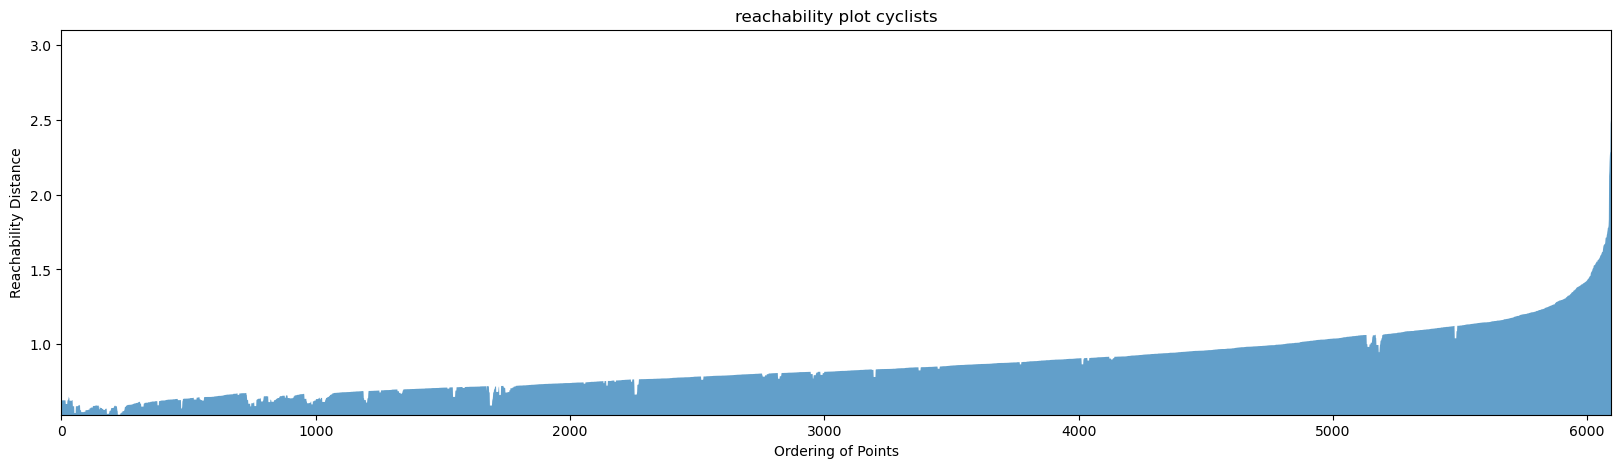

In [119]:
reachability=best_optics_params['reachability']
ordering=best_optics_params['ordering']
reachability_plot("cyclists",reachability=reachability,ordering=ordering)